In [1]:
from requests import get
from json import dumps
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import datetime
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO
import scipy
import math

In [2]:
def N_avg(a, N=7):
    # weekly avg into the past, shorten a
    b = np.zeros(len(a)-N)
    for i in range(N,len(a),1):
        b[i-N] = np.mean(a[i-N:i])
    return b

def N_avg_hard(a, N=3):
    # hard edged rolling avg, preserve len(a) by nan-ing
    b = np.zeros(len(a))
    b[:] = np.nan
    for i in range(N,len(a)-N,1):
        b[i] = np.mean(a[i-N:i+N])
    return b

def N_avg_soft(a, N=3):
    # soft edged rolling avg, preseve len a 
    b = np.zeros(len(a))
    for i in range(len(a)):
        l = max(0,i-N)
        r = min(i+N+1, len(a))
        b[i] = np.mean(a[l:r])
    return b

def diff_axis(scale, ax1, ax2):
    _,l1 = ax1.get_ylim()
    _,l2 = ax2.get_ylim()
    d1 = np.array(ax1.lines[0].get_ydata())
    d2 = np.array(ax2.lines[0].get_ydata())
    return np.mean(np.abs(d1/scale-d2))
    
def match_axis(ax1, ax2):
    scale = scipy.optimize.minimize(diff_axis, 1, args=(ax1,ax2))
    _,l2 = ax2.get_ylim()
    ax1.set_ylim(0,l2*scale.x)  
    return scale.x

In [3]:
# download api data for England
req = "https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=E92000001&metric=newAdmissions&metric=hospitalCases&metric=covidOccupiedMVBeds&format=json"
response = get(req, timeout=10)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')
response = response.json()

df_england = pd.DataFrame(response['body'])
df_england['dateTime'] = pd.to_datetime(df_england['date'])
df_england.sort_values(by=['dateTime'], inplace=True)
df_england.dropna(inplace=True)

top_date = sorted(list(set(df_england.dateTime.to_list())))[-1].strftime("%Y-%m-%d")
print(top_date)

2021-12-27


In [4]:
# download api data for regions
req = "https://api.coronavirus.data.gov.uk/v2/data?areaType=nhsRegion&metric=newAdmissions&metric=hospitalCases&metric=covidOccupiedMVBeds&format=json&format=json"
response = get(req, timeout=10)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')
response = response.json()

df_regions_nhs = pd.DataFrame(response['body'])
df_regions_nhs['dateTime'] = pd.to_datetime(df_regions_nhs['date'])
df_regions_nhs.sort_values(by=['dateTime'], inplace=True)
df_regions_nhs.dropna(inplace=True)

top_date_nhs = sorted(list(set(df_regions_nhs.dateTime.to_list())))[-1].strftime("%Y-%m-%d")
print(top_date_nhs)


2021-12-27


In [5]:
train_in_stream = []
train_out_stream = []
dates_train = []

test_in_stream = []
test_out_stream = []
dates_test = []


in_event = ""
out_event = ""
geographical_context = ""

train_start_date = "2021-09-01" 
train_end_date = "2021-12-01"
test_start_date = "2021-10-01"
test_end_date = top_date

In [6]:
# set: England hosp admissions -> hosp occupancy
df = df_england
train_df = df[(df.dateTime >= train_start_date) & (df.dateTime <= train_end_date)]
test_df = df[(df.dateTime >= test_start_date) & (df.dateTime <= test_end_date)]

train_in_stream = np.array(train_df.newAdmissions.to_list(), dtype=float)
train_out_stream = np.array(train_df.hospitalCases.to_list(), dtype=float)
test_in_stream = np.array(test_df.newAdmissions.to_list(), dtype=float)
test_out_stream = np.array(test_df.hospitalCases.to_list(), dtype=float)
dates_train = sorted(list(set(train_df.dateTime.to_list())))
dates_test = sorted(list(set(test_df.dateTime.to_list())))

in_event = "hospital admission"
out_event = "hospital occupancy"
geographical_context = "England"

In [7]:
# set: regional hosp admissions -> hosp occupancy
region = "London"
df = df_regions_nhs[df_regions_nhs.areaName==region]
train_df = df[(df.dateTime >= train_start_date) & (df.dateTime <= train_end_date)]
test_df = df[(df.dateTime >= test_start_date) & (df.dateTime <= test_end_date)]
train_in_stream = np.array(train_df.newAdmissions.to_list(), dtype=float)
train_out_stream = np.array(train_df.hospitalCases.to_list(), dtype=float)
test_in_stream = np.array(test_df.newAdmissions.to_list(), dtype=float)
test_out_stream = np.array(test_df.hospitalCases.to_list(), dtype=float)
dates_train = sorted(list(set(train_df.dateTime.to_list())))
dates_test = sorted(list(set(test_df.dateTime.to_list())))

in_event = "hospital admission"
out_event = "hospital occupancy"
geographical_context = region

In [8]:
#train_in_stream = N_avg(train_in_stream)
#train_out_stream = N_avg(train_out_stream)
#test_in_stream = N_avg(test_in_stream)
#test_out_stream = N_avg(test_out_stream)

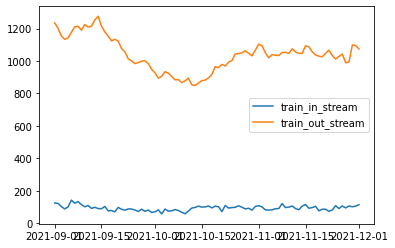

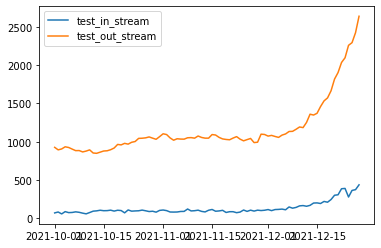

In [9]:
plt.clf()
plt.plot(dates_train, train_in_stream, label="train_in_stream")
plt.plot(dates_train, train_out_stream, label="train_out_stream")
plt.legend()
plt.show()
plt.clf()
plt.plot(dates_test, test_in_stream, label="test_in_stream")
plt.plot(dates_test, test_out_stream, label="test_out_stream")
plt.legend()
plt.show()

In [10]:
def cumsumflip(x):
    return np.flip(np.cumsum(np.flip(x)))

def _g(x, in_stream, out_stream):
    # model out_stream as a convolution of in_stream with x
    target_out_stream = out_stream[len(x)-1:]
    _x = cumsumflip(x)
    pred_out_stream = np.convolve(in_stream, _x, mode="valid")
    return target_out_stream, pred_out_stream

def g(xs, in_stream=train_in_stream, out_stream=train_out_stream):
    ret = np.zeros(np.shape(xs)[0])
    for i in range(len(ret)):
        x = xs[i,:]
        target_out_stream, pred_out_stream = _g(x, in_stream, out_stream)
        ret[i] = np.sum(np.abs(pred_out_stream - target_out_stream)) / len(pred_out_stream)
    return ret        

In [11]:
n_dim = 40
n_particles = 2000

x_max = 0.1*np.ones(n_dim)
x_min = -0.01*np.ones(n_dim)
options = {'c1': 0.5, 'c2': 0.1, 'w': 0.65}
bounds = (x_min, x_max)
init_pos = None #np.array([np.zeros(n_dim) for i in range(n_particles)])

_minimizers = []

for i in range(10):
    optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=n_dim, options=options, bounds=bounds, init_pos=init_pos)
    cost, pos = optimizer.optimize(g, 1000, verbose=True, n_processes=10)
    _minimizers.append(pos)
minimizers = np.array(_minimizers)

2021-12-30 15:17:27,436 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.1, 'w': 0.65}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=19.1
2021-12-30 15:17:41,373 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 19.1488892615109, best pos: [ 3.50100448e-02  6.48101424e-02  3.87850165e-02  3.80023892e-02
  3.55836768e-02  5.37229637e-02  1.65443353e-02  2.63848407e-02
  4.15630978e-02  1.84834450e-02  1.71048343e-02  2.20973185e-02
  3.78162618e-02  2.63615714e-02  1.92969225e-02  1.90392477e-02
  6.89142439e-02  2.79075178e-02  1.41157254e-02  1.84617710e-02
  2.28583896e-02  1.17982164e-02  3.41284184e-02  1.93079242e-02
  6.28487966e-03  2.94940623e-02  3.32114986e-02  1.92755430e-02
  1.37460606e-02  9.86561636e-03  2.89752242e-03  1.33924010e-03
  1.28759404e-02 -3.11071534e-03 -5.63139434e-05  1.26763476e-02
 -5.49777047e-03 -2.06389929e-03 -6.70617207e-03 -8.42359697e-03]
2021-12-30 15:17:41,393 - 

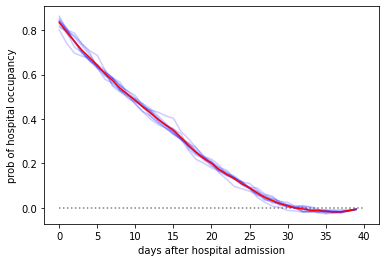

<Figure size 432x288 with 0 Axes>

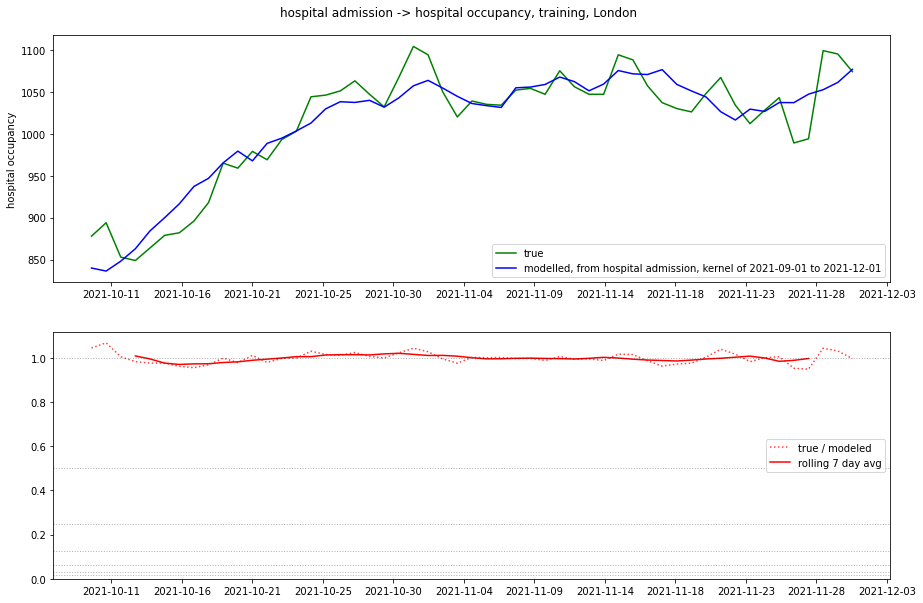

<Figure size 432x288 with 0 Axes>

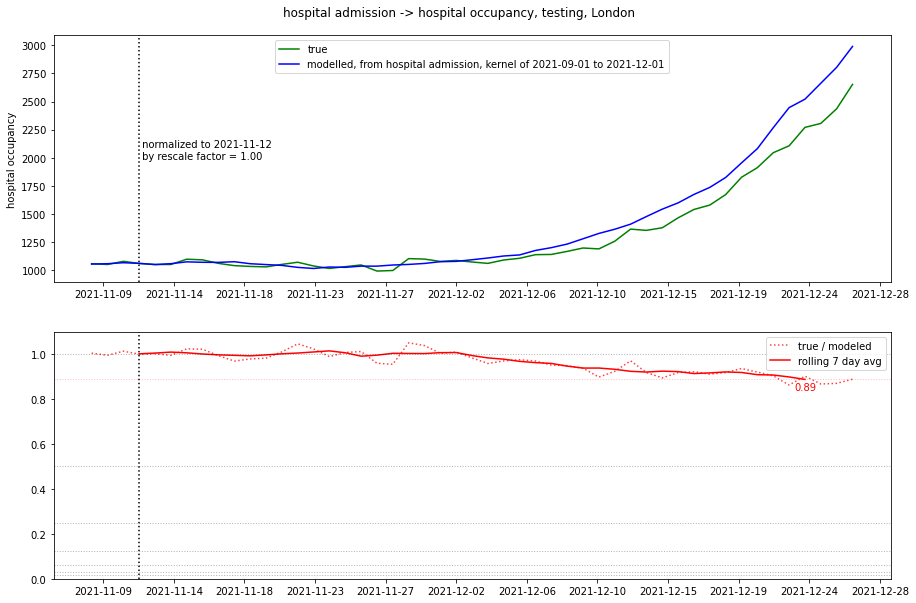

In [22]:
# show kernel
plt.clf()
z = list(range(len(pos)))
for y in minimizers:
    plt.plot(z, cumsumflip(y), color="blue", alpha=0.2)
avg_minimizer = []
for i in range(len(minimizers[0])):
    avg_minimizer.append(np.mean(minimizers[:,i]))
avg_minimizer = np.array(avg_minimizer)
plt.plot(z, cumsumflip(avg_minimizer), color="red", alpha=1)
plt.xlabel("days after %s" % in_event)
plt.ylabel("prob of %s" % out_event)
plt.hlines(0, 0,len(z), ls="dotted", alpha=0.5, color="black")
plt.savefig("%s__%s__kernel.png" % (in_event, out_event), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

def log2(a):
    return math.log2(a) if a>0 else math.log2(-a) if a<0 else 0

# show fit to training & testing
def make_graph(dates, kernel, in_stream, out_stream, test_train):
    plt.clf()
    assert(len(in_stream)==len(out_stream))
    assert(len(kernel)<=len(in_stream))
    fig, axes = plt.subplots(2,1, figsize=(15,10))
    ax1,ax2 = axes   
    
    true, pred = _g(avg_minimizer, in_stream, out_stream) 
    x = dates[-len(true):]
    diff = true/pred
    avg_diff = N_avg_hard(diff, 3)
    rescale_factor = 1
    if test_train=="test":
        rescale_factor = avg_diff[np.isfinite(avg_diff)][0]
    
    ax1.plot(x, true/rescale_factor, color="green", label="true")
    modeled_label = "modelled, from %s, kernel of %s to %s" % (in_event, train_start_date, train_end_date)
    ax1.plot(x, pred, color="blue", label=modeled_label)
    ax1.set_ylabel("%s" % out_event)
    ax1.legend()
    n_marks = 11
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(len(x)/n_marks))
    
    ax2.plot(x, diff/rescale_factor, color="red", alpha=0.75, ls="dotted", label="true / modeled")
    ax2.plot(x, avg_diff/rescale_factor, color="red", label="rolling 7 day avg")
    for i in range(7):
        ax2.axhline(y=2**(-i), ls="dotted", lw=1, alpha=0.3, color="black")        
    ax2.set_ylim(0,None)
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(len(x)/n_marks))

    if test_train=="test":
        end_level = avg_diff[np.isfinite(avg_diff)][-1]
        ax2.axvline(x=x[3], color="black", ls="dotted")
        ax1.axvline(x=x[3], color="black", ls="dotted")
        y_min,y_max = ax1.get_ylim()
        y_mid = (y_min+y_max)/2 
        ax1.text(x[3], y_mid, " normalized to %s\n by rescale factor = %.2f" % (x[3].strftime("%Y-%m-%d"), rescale_factor), ha="left")
        ax2.axhline(y=end_level/rescale_factor, color="red", alpha=0.25, ls="dotted", lw=1)
        ax2.text(x[-4], end_level/rescale_factor-0.05, "%.2f" % (end_level/rescale_factor), ha="center", color="red")    
    
    ax2.legend()
    fig.suptitle("%s -> %s, %sing, %s" % (in_event, out_event, test_train, geographical_context), y=0.92)
    plt.savefig("%s__%s__%s__%s.png" % (in_event, out_event, test_train, geographical_context), bbox_inches='tight', facecolor='white', transparent=False)
    plt.show()
    
make_graph(dates_train, avg_minimizer, train_in_stream, train_out_stream, "train") 
make_graph(dates_test, avg_minimizer, test_in_stream, test_out_stream, "test") 





In [17]:
print(cumsumflip(avg_minimizer))

[ 8.34371112e-01  7.90700208e-01  7.48838903e-01  7.08950555e-01
  6.75919868e-01  6.41088903e-01  6.04426076e-01  5.72662278e-01
  5.38747816e-01  5.09871357e-01  4.82811545e-01  4.53346200e-01
  4.26467497e-01  3.97144088e-01  3.72343049e-01  3.48335259e-01
  3.16425160e-01  2.80473269e-01  2.48744244e-01  2.22023657e-01
  2.00200986e-01  1.72116640e-01  1.50801478e-01  1.30328559e-01
  1.08268476e-01  8.94195834e-02  6.70906580e-02  4.58269223e-02
  3.24497127e-02  1.84209082e-02  7.99369485e-03 -3.96441937e-04
 -5.70146607e-03 -1.11771672e-02 -1.37890564e-02 -1.69647220e-02
 -1.81765764e-02 -1.84839704e-02 -1.34451495e-02 -7.23403122e-03]
